# Генерация текста с помощью RNN


(по мотивам [семинара](https://github.com/neychev/harbour_dlia2019/blob/master/day02_Simple_RNN/Day_2_Simple_RNN_pytorch.ipynb)
 [курса "Deep Learning in Applications"](https://in.harbour.space/data-science/deep-learning-in-applications-radoslav-neychev-anastasia-ianina/))

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Данные
Датасет содержит ~9k имен, все написаны латиницей.

In [3]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('datasets/russian_names.txt') as input_file:
    names = input_file.read()[:-1].split('\n')
    names = [' ' + line for line in names]

In [4]:
names[:5]

[' Ababko', ' Abaev', ' Abagyan', ' Abaidulin', ' Abaidullin']

Посмотрим на распределение длин имен:

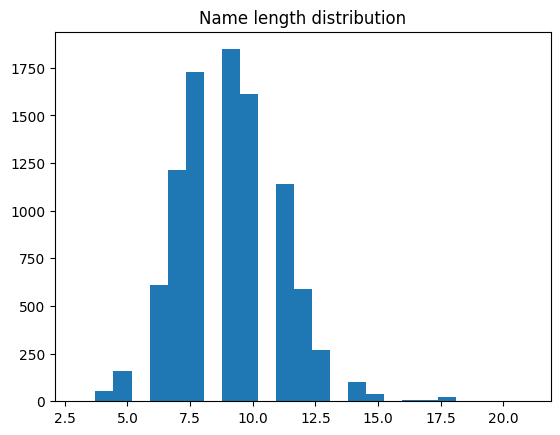

In [5]:
plt.title('Name length distribution')
plt.hist(list(map(len, names)), bins=25);

# Препроцессинг

In [6]:
#all unique characters go here
tokens = list(set(''.join(names)))

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  53


### Символы -> id

Создадим словарь < символ > -> < id >

In [7]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [8]:
token_to_id

{'U': 0,
 'm': 1,
 'j': 2,
 'T': 3,
 'f': 4,
 'y': 5,
 'G': 6,
 'V': 7,
 'u': 8,
 'M': 9,
 'l': 10,
 ',': 11,
 'C': 12,
 'L': 13,
 'n': 14,
 '-': 15,
 'g': 16,
 'B': 17,
 'v': 18,
 '\xa0': 19,
 's': 20,
 'D': 21,
 'S': 22,
 'k': 23,
 'b': 24,
 'e': 25,
 't': 26,
 'J': 27,
 'Z': 28,
 'i': 29,
 'p': 30,
 'O': 31,
 'N': 32,
 'H': 33,
 'E': 34,
 'В': 35,
 'r': 36,
 "'": 37,
 'Y': 38,
 'w': 39,
 'K': 40,
 'h': 41,
 'R': 42,
 'I': 43,
 'A': 44,
 'o': 45,
 'a': 46,
 'd': 47,
 'z': 48,
 'F': 49,
 'P': 50,
 ' ': 51,
 'c': 52}

In [9]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [10]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [11]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000], token_to_id))

 Ababko
 Chihachev
 Isaikov
 Nakhamkin
 Ustenko
[[51 44 24 46 24 23 45 51 51 51]
 [51 12 41 29 41 46 52 41 25 18]
 [51 43 20 46 29 23 45 18 51 51]
 [51 32 46 23 41 46  1 23 29 14]
 [51  0 20 26 25 14 23 45 51 51]]


# Рекуррентные нейронные сети

<img src="img/rnn.png" width=480>

In [12]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [13]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [14]:
char_rnn = CharRNNCell()

### Тренировка сети, RNN loop

In [15]:
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

### Тренировка сети

In [16]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

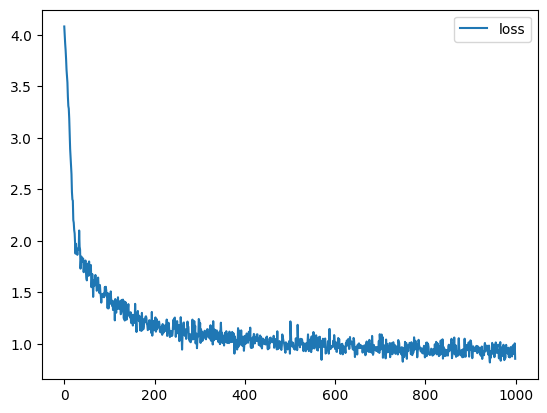

In [17]:
MAX_LENGTH = max(map(len, names))

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: генерация имен

In [18]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [19]:
for _ in range(10):
    print(generate_sample(char_rnn))

 Vaichov             
 Ruhrin              
 Vaschikov           
 Tsiptulov           
 Aveten              
 Alerchovtov         
  Haraenkov          
 Garinan             
 Pabenelko           
 Lov                 


In [20]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' Sa'))

 Sanikh              
 Sagorosky           
 Saadorshi           
 Sarkeretsov         
 Saetenshan          
 Sahnano             
 Sadidenlan          
 Sarubit             
 Sanabtukins         
 Samsiliv            


### Более простое решение

* `nn.RNNCell(emb_size, rnn_num_units)` - шаг RNN. Алгоритм: concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - весь rnn_loop.

Кроме того, в PyTorch есть `nn.LSTMCell`, `nn.LSTM`, `nn.GRUCell`, `nn.GRU`, etc. etc.

Перепишем наш пример с генерацией имен с помощью средств PyTorch.

In [21]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens, emb_size=16, rnn_num_units=64, rnn_num_layers=1):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.rnn_num_layers = rnn_num_layers
        
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, num_layers=self.rnn_num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        output, h_seq = self.rnn(self.emb(x), h)
        next_logits = self.hid_to_logits(output)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, h_seq
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(self.rnn_num_layers, batch_size, self.num_units))
    
model = CharRNNLoop(num_tokens=len(tokens))
opt = torch.optim.Adam(model.parameters())
history = []

In [22]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_LENGTH)
batch_ix = Variable(torch.LongTensor(batch_ix))

batch_size = batch_ix.size()[0]
h0 = model.initial_state(batch_size)
logp_seq, h = model(batch_ix, h0)

# compute loss
loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens), 
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

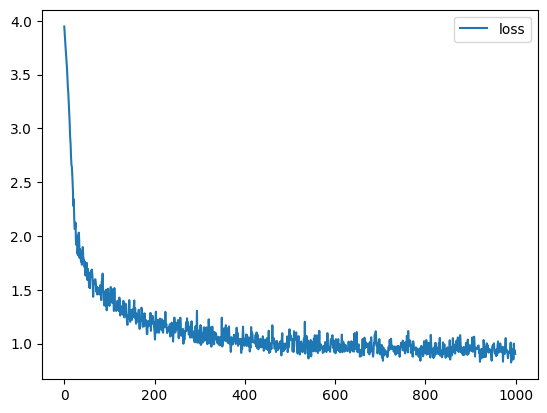

In [23]:
MAX_LENGTH = max(map(len, names))

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    batch_size = batch_ix.size()[0]
    h0 = model.initial_state(batch_size)
    
    logp_seq, h = model(batch_ix, h0)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [24]:
def generate_rnn_sample(model, token_to_id, token_len, max_length, seed_phrase=' ', temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [[token_to_id[token] for token in seed_phrase]]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    hid_state = model.initial_state(batch_size=1)
    
#     #feed the seed phrase, if any
    for i in range(len(seed_phrase)-1):
        _, hid_state = model(x_sequence[:, :, i], hid_state)
    
    #start generating
    for _ in range(max_length-len(seed_phrase)):
        logp_next, hid_state = model(x_sequence[:, :, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0][0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(token_len, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix.unsqueeze(1)], dim=2)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [25]:
for _ in range(10):
    print(generate_rnn_sample(model=model, token_to_id=token_to_id, token_len=len(token_to_id), max_length=MAX_LENGTH))

 Pyzanofr            
 Chidlchenk          
 Vurbilov            
 Barkhenov           
 Gulien              
 Mahev               
 Gzchetnkov          
 Tultsicenk          
 Abraushef     Ly    
 Vilinhin            


### Домашнее задание: мотивационные лозунги

In [26]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('datasets/author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' ' + line for line in quotes]

In [27]:
quotes[:5]

[' If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.',
 " Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.",
 ' Did you ever stop to think, and forget to start again?',
 ' Organizing is what you do before you do something, so that when you do it, it is not all mixed up.',
 ' Weeds are flowers too, once you get to know them.']

In [28]:
tokens = list(set(''.join(quotes)))
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)

In [29]:
len(token_to_id)

88

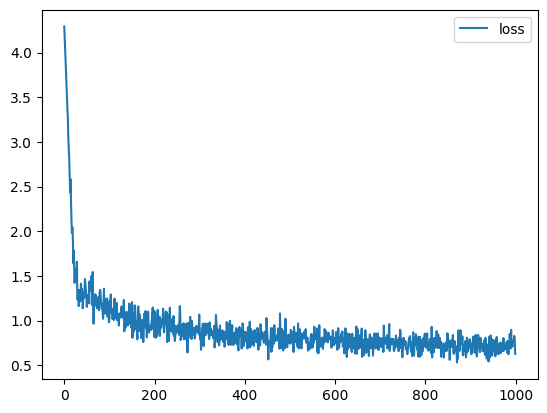

In [30]:
model = CharRNNLoop(num_tokens=len(token_to_id), rnn_num_units=64, rnn_num_layers=1)
opt = torch.optim.Adam(model.parameters())
history = []
MAX_LENGTH = max(map(len, quotes))

for i in range(1000):
    batch_ix = to_matrix(sample(quotes, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    batch_size = batch_ix.size()[0]
    h0 = model.initial_state(batch_size)
    
    logp_seq, h = model(batch_ix, h0)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [31]:
for _ in range(10):
    print(generate_rnn_sample(model=model, token_to_id=token_to_id, token_len=len(token_to_id), max_length=len(token_to_id), seed_phrase=' '))

 Wyrat innd on th'bq as cnotis emalwisl, mome.                                          
 Thefacftillis:the beserpeveaks welield .rape aded on thillys mvamenst ledree Il that, r
 M ofint hing ther, rut gheathacf tinhiversiib deal on, of oleg ars.                    
 Bus gaves ous ellage the us fpeechext and it, a mant's ays be exus a fithoun o gte fees
 I fhand the woreus wilkeltows bes whonuthod hure no word sraditop atZancit'tcry pund;re
 I To  fmond eoryo forsponat, weres mit he taus ivering it. I  mur bulcod. Th,. batt  nr
 W the wourithd the burvechich to! yh tor af timix To ver thant ouluinte sees un bukturt
 Noterlacile,  toy foek of of ham pad scicerted.                                        
 вutot buyt hewpay,' then the fey manwicrith . thate of ac. we whucry kald is mere ald d
 I sformery aberte a ssorimef miElsick, csianding thmat gy, ecatt.                      


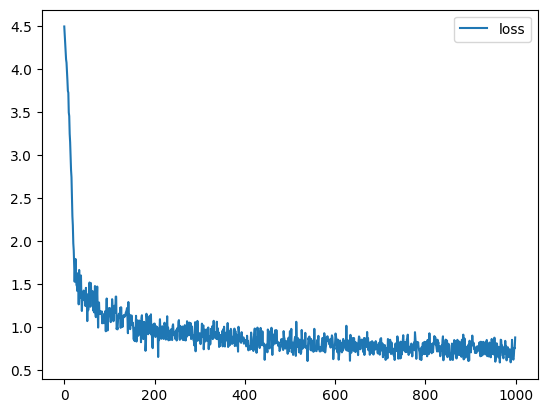

In [32]:
char_rnn = CharRNNCell(num_tokens=len(token_to_id))
opt = torch.optim.Adam(char_rnn.parameters())
history = []
MAX_LENGTH = max(map(len, quotes))

for i in range(1000):
    batch_ix = to_matrix(sample(quotes, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [33]:
for _ in range(10):
    print(generate_sample(char_rnn, max_length=MAX_LENGTH))

 Whes lenoSf frengoms wect. r helusseak aracisi lismere thaH  Yoca sullnfusfio2 you me coulis arlor sheriksunit celeviry%us the gonos ind a decrot orys whis acals ifeyug in apde arthers and beive ricerioc at o. n'y ant o cunchouratos af me asten weoue sore onig micrre,s lhikzabs.                                                                                                                                     
 I8k oisung.                                                                                                                                                                                                                                                                                                                                                                                                                 
 V                                                                   A                                                                                                      

### Что еще можно генерировать?
С помощью кода из этого семинара можно генерировать не только имена, но и:

* Повести/романы/поэзию/песни любимого автора
* Новостные заголовки
* Программный код
* Молекулы в формате [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)
* Музыку
* Названия мебели из ИКЕА
* Мотивационные лозунги
* etc.

__Удачи!__